In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns


import statsplot as stp
from statsplot import MetaTable

# Simple example

We create first some dummy data for weights for three treatments


In [2]:
np.random.seed(0)


N = 8
group_names = ["Control", "Treatment 1", "Treatment 2"]

groups = pd.Series(
    np.repeat(group_names, N),
    index=[f"Participant_{i+1}" for i in range(N * len(group_names))],
    name="Group",
)
weights = pd.Series(
    data=np.random.randn(groups.shape[0], 1)[:, 0] * 5 + 15,
    index=groups.index,
    name="Weight",
)
# add difference between groups
weights += groups.map(dict(zip(group_names, [0, 0.1, 10]))).values

We can plot this data elegantly with seaborn

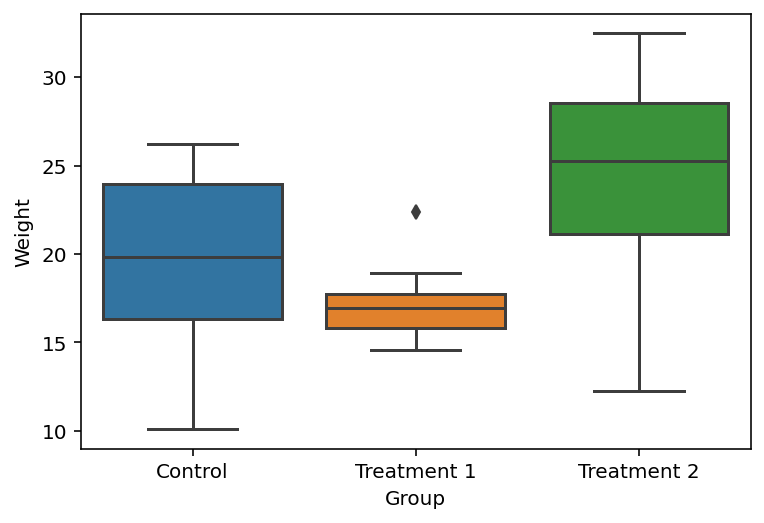

In [3]:
ax = sns.boxplot(y=weights, x=groups)

If you want to know and plot significance on the plot we can simply use satatsplot with almost the same API

Treatment 1_vs_Control        0.338836
Treatment 2_vs_Control        0.117191
Treatment 2_vs_Treatment 1    0.010854
Name: Weight, dtype: float64

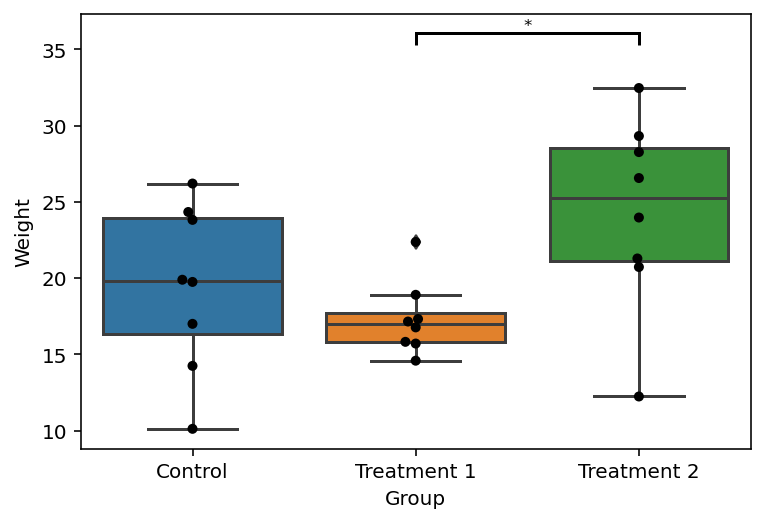

In [4]:
ax, stats = stp.statsplot(variable=weights, test_variable=groups)

stats

If you want to show the value instead of the start you can modify the sig labels.

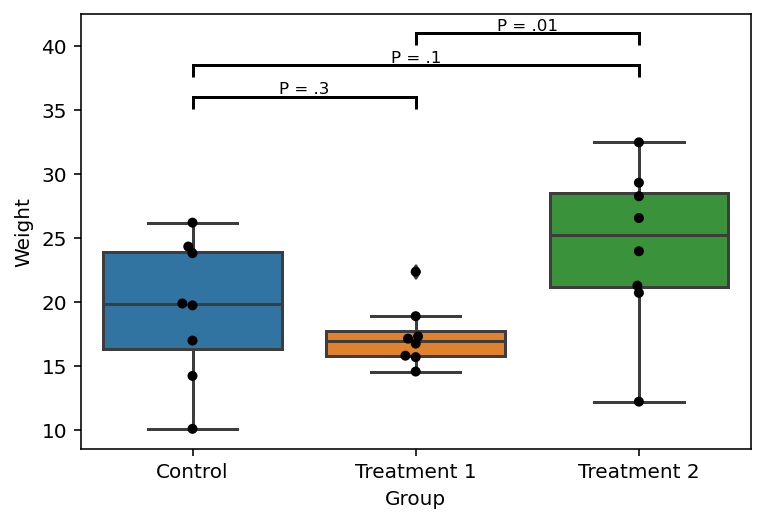

In [5]:
ax, stats = stp.statsplot(
    variable=weights,
    test_variable=groups,
    labelkws={"show_ns": True, "use_stars": False},
)

# Example with nested groups

In [6]:
# create data from above groups with before treatment and after treatment time point

df = pd.DataFrame(groups).reset_index().rename(columns={"index": "Participant"})

df_before = df.copy()
df_before["Timepoint"] = "before"
df_before["Measurement"] = np.random.randn(df.shape[0], 1)[:, 0] * 5 + 12

df_after = df.copy()
df_after["Timepoint"] = "after"
df_after["Measurement"] = weights.values

df = pd.concat([df_before, df_after], ignore_index=True)
del df_before, df_after

df.index = "Sample_" + df.index.astype(str)

df.head()

,Participant,Group,Timepoint,Measurement
Sample_0,Participant_1,Control,before,23.348773
Sample_1,Participant_2,Control,before,4.728172
Sample_2,Participant_3,Control,before,12.228793
Sample_3,Participant_4,Control,before,11.064081
Sample_4,Participant_5,Control,before,19.663896


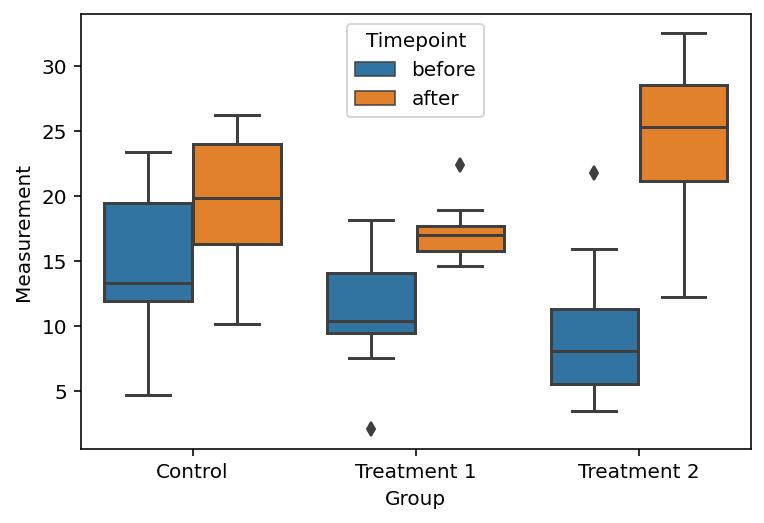

In [7]:
ax = sns.boxplot(
    data=df, y="Measurement", hue="Timepoint", x="Group", hue_order=["before", "after"]
)

Control      before_vs_after    0.120447
Treatment 1  before_vs_after    0.013041
Treatment 2  before_vs_after    0.005731
Name: Measurement, dtype: object

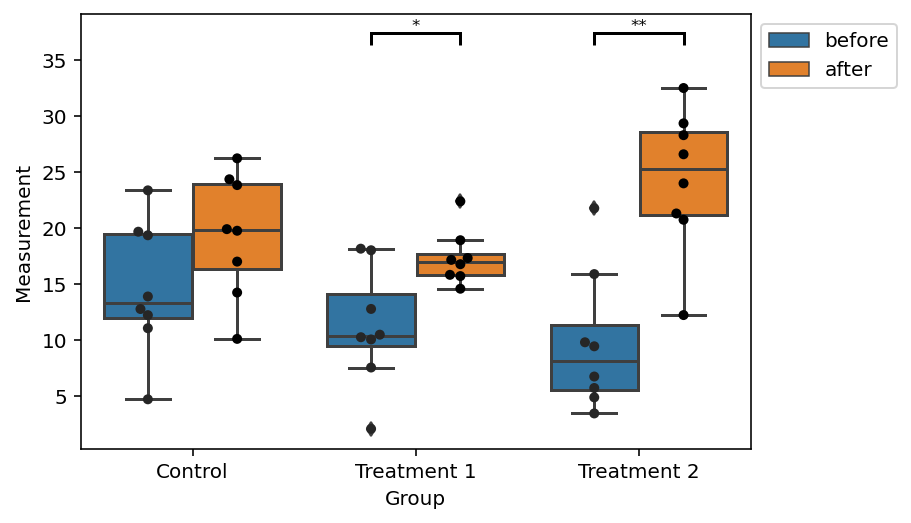

In [8]:
# and here the statsplot version of it.
# see we use paired ttest as we compate the same patients before and after treatment

ax, stats = stp.statsplot(
    variable=df.Measurement,
    test_variable=df.Timepoint,
    grouping_variable=df.Group,
    test="ttest_rel",
    order_test=["before", "after"],
)
stats

# Example with many variables

If you have many similar values you can put them in a `StatsTable` and then apply statistics once.
This example is based on on microbiome profiling

In [9]:
relab = pd.read_table("test/data/micobiota_relab.tsv.gz", index_col=0)

Tax = pd.read_table("test/data/micobiota_taxonomy.tsv.gz", index_col=0)

metadata = pd.read_table("test/data/micobiota_metadata.tsv.gz", index_col=0)

In [10]:
# transform data with centered log transform
from statsplot import transformations

clr_data = transformations.clr(relab, log=np.log2)

# put everithing together in a MetaTable

D = MetaTable(clr_data, obs=metadata, var=Tax)

In [11]:
# create stats table

ST = stp.StatsTable(
    D,
    test_variable="Group",
    grouping_variable="Source",
    label_variable="Label",
    data_unit="centered log$_2$ ratio",
    test="welch",
    ref_group="RT",
)

Your labels are not unique. but I should be able to handle this.


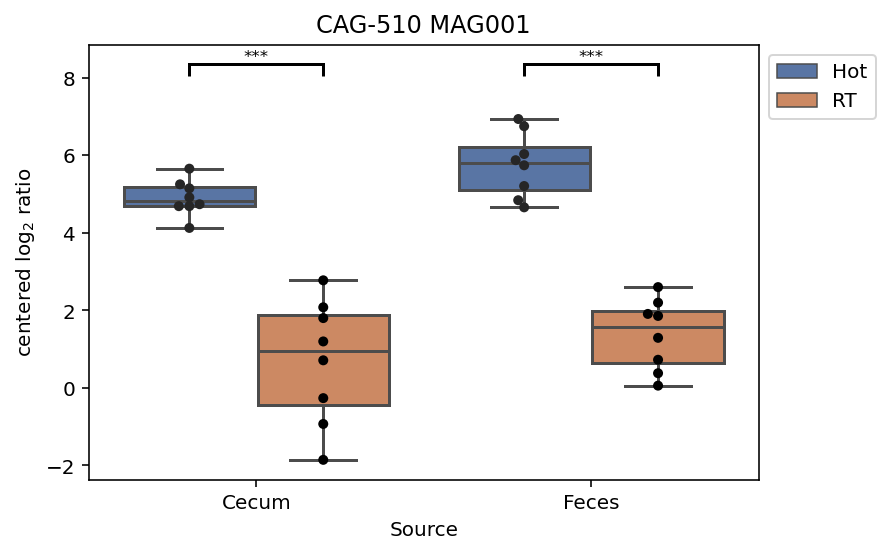

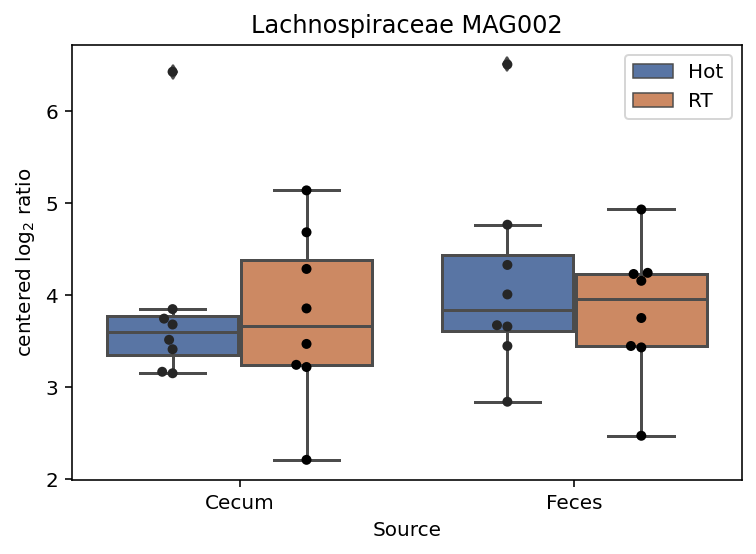

In [12]:
ST.plot("MAG001")
plt.show()
ST.plot("MAG002")

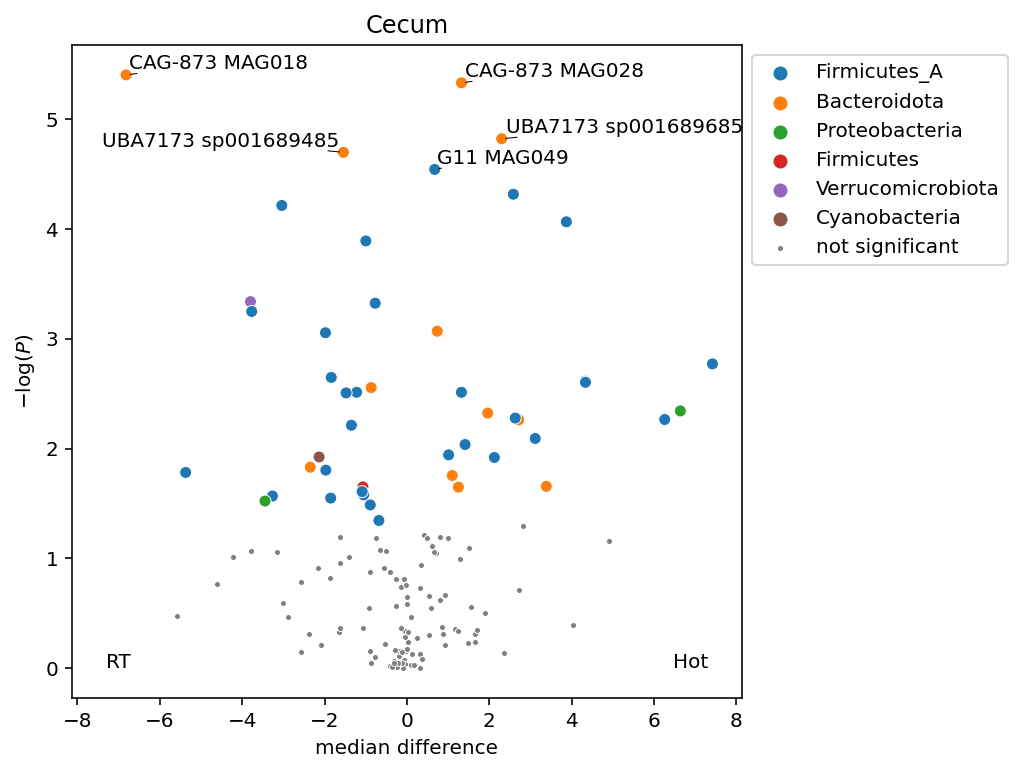

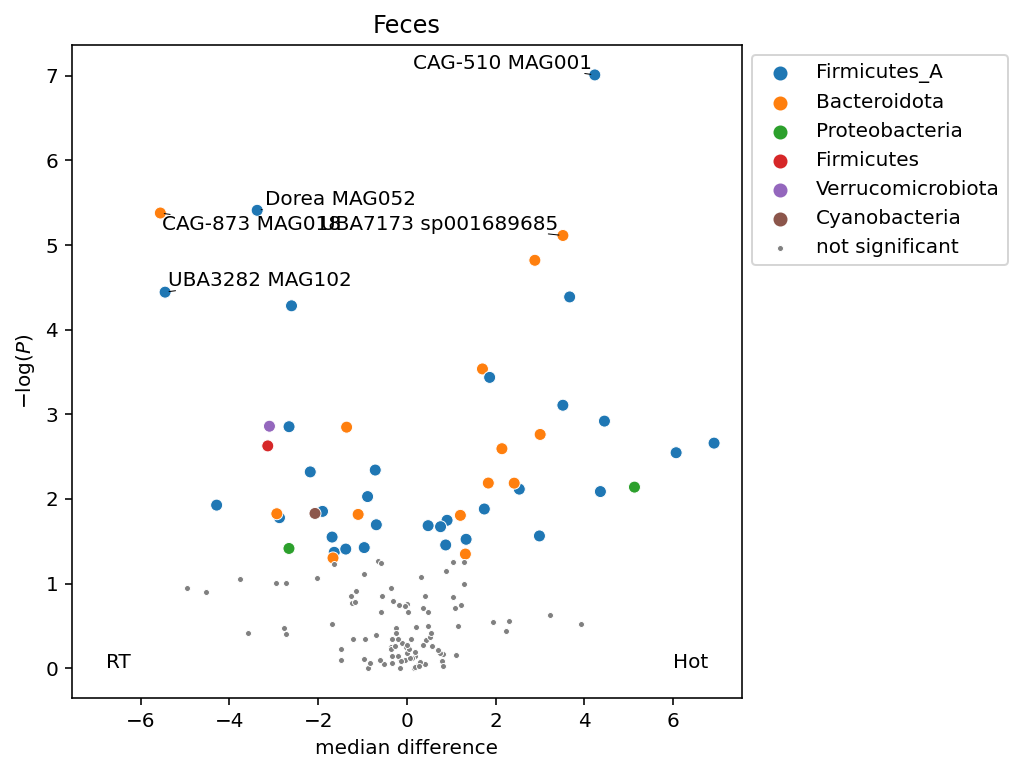

In [13]:
# make a vulcanot

axes = ST.vulcanoplot(hue="phylum")

# PCA

The following functions represent commonly used plots for dimensional reduction


In [14]:
from statsplot import DimRed

pca = DimRed(clr_data)

<AxesSubplot:xlabel='Principal Component', ylabel='Explained Variance Ratio'>

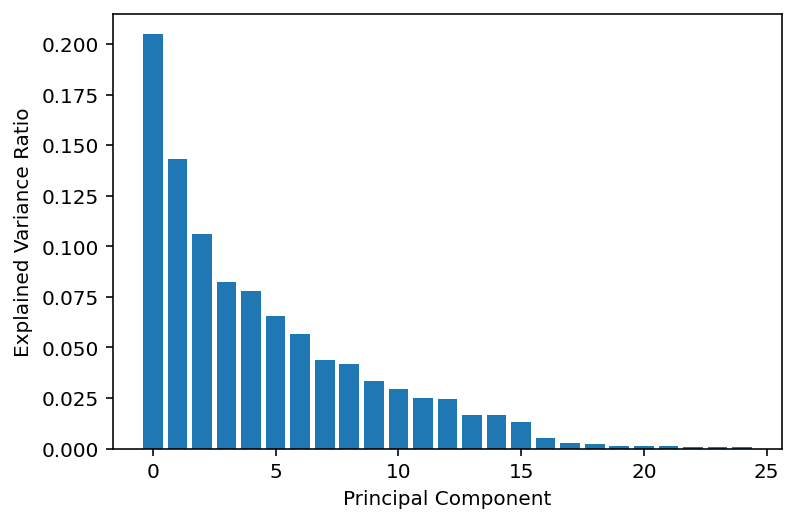

In [15]:
pca.plot_explained_variance_ratio()

<AxesSubplot:xlabel='PC 1 [20.5 %]', ylabel='PC 2 [14.3 %]'>

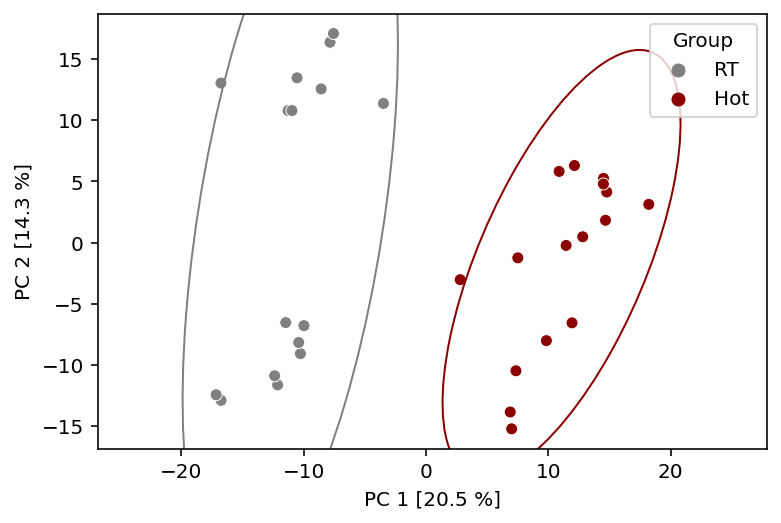

In [16]:
pca.plot_components(
    plot_ellipse=True,
    groups=metadata.Group,
    order_groups=["RT", "Hot"],
    colors=["grey", "darkred"],
)

<AxesSubplot:xlabel='PC 1 [20.5 %]', ylabel='PC 2 [14.3 %]'>

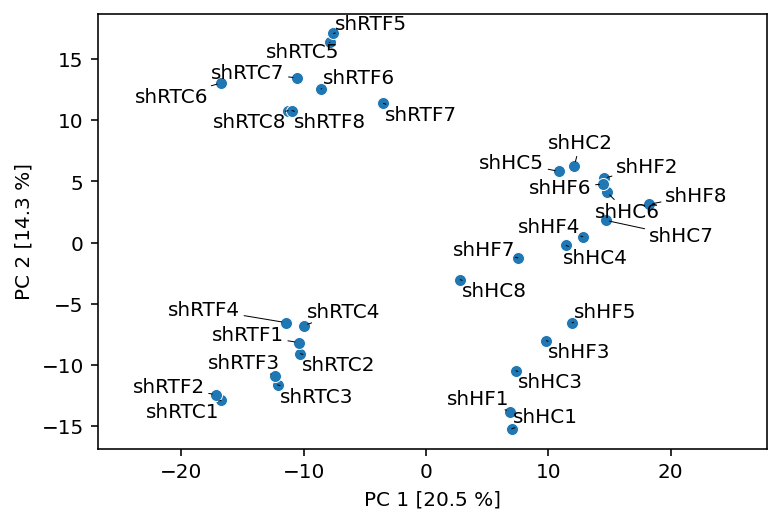

In [17]:
pca.plot_components(label_points=True)

automatic selection selected 10 to visualize, which is probably to much. I select only 8


<AxesSubplot:xlabel='PC 1 [20.5 %]', ylabel='PC 2 [14.3 %]'>

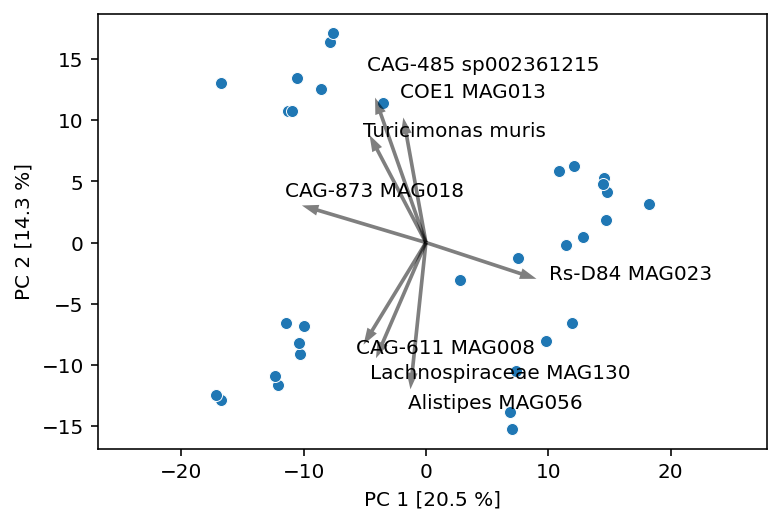

In [18]:
pca.plot_biplot(labels=Tax.Label)

# Stats table with one grouping variable 

This is to show how to construct a statstable without the MetaTable and for testing

In [19]:
# create stats table

ST = stp.StatsTable(
    relab,
    test_variable=metadata.Group,
    label_variable=Tax.Label,
    data_unit="Relative abundance",
    test="mannwhitneyu",
    ref_group="RT",
)

Your labels are not unique. but I should be able to handle this.


[<AxesSubplot:xlabel='$\\log_2FC$', ylabel='$-\\log(P)$'>]

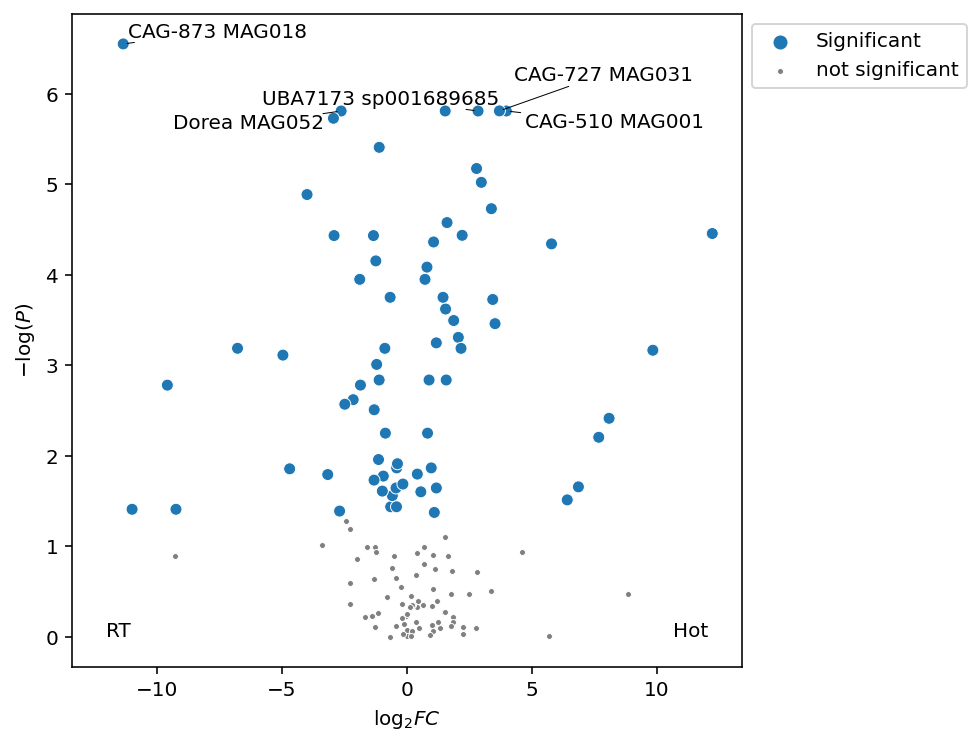

In [20]:
ST.vulcanoplot()

In [21]:
ST.stats
# keep in mind that the stats table here has one header row less than if used with a grouping variable

,Pvalue,Statistic,log2FC,median_diff,pBH,Description
,Hot_vs_RT,Hot_vs_RT,Hot_vs_RT,Hot_vs_RT,Hot_vs_RT,Label
MAG001,0.000002,0.0,3.979037,4.355420,0.000038,CAG-510 MAG001
MAG002,0.462380,108.0,0.413565,0.155043,0.596227,Lachnospiraceae MAG002
MAG003,0.338839,106.0,1.745871,0.000000,0.488326,Bacteroides sp002491635
MAG004,0.010959,196.0,-1.138110,-0.081953,0.032220,Lachnospiraceae MAG004
MAG005,0.000975,216.0,-1.211975,-0.668275,0.003872,UBA7050 MAG005
...,...,...,...,...,...,...
MAG143,0.003091,207.0,-1.311170,-0.851287,0.010096,Zag111 MAG143
MAG144,0.038849,160.0,-9.247887,0.000000,0.081583,Oscillospiraceae MAG144
MAG145,0.005603,54.0,0.824869,0.233811,0.017160,CAG-180 MAG145


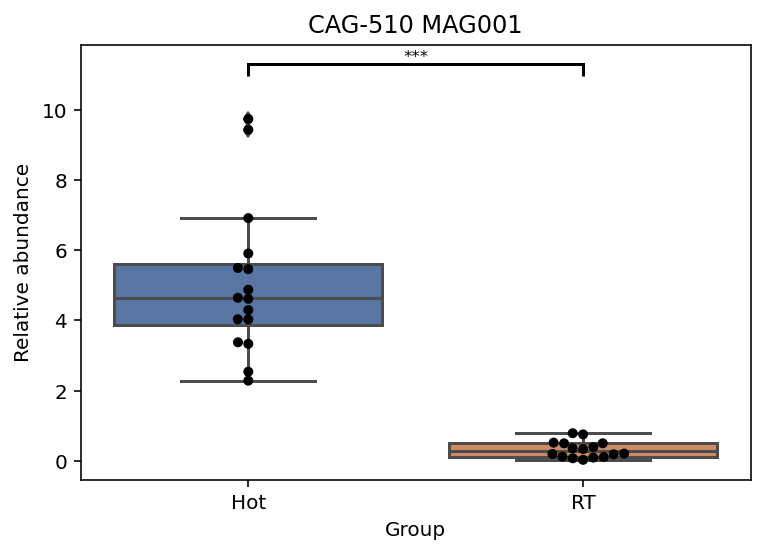

In [22]:
ST.plot("MAG001")